<a href="https://colab.research.google.com/github/KaiHaVertzz29/G20-project/blob/main/G20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color=#D5B85A> Importing Required Packages

In [11]:
import pandas as pd
import glob
pd.options.mode.chained_assignment = None
import plotly.express as px
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from scipy.stats import zscore
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,r2_score

## <font color=#D5B85A> Time Series Analysis</font>
- data is from IMF of per_capita_income across g20_countries
- Years considered = [2011-2022]

In [18]:
g20_data=pd.read_excel('popular_indicators.xlsx',sheet_name=None)

In [19]:
columns=['per_capita','percentage_change_g20','Governement_spen_per_of_gdp','change_in_per']

In [20]:
pc_data=g20_data[columns[1]]

In [21]:
pc_data.columns

Index(['country Name ', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'],
      dtype='object')

### <font color=#FFA07A> Melting the data to create rows from columns for better  EDA  </font>


In [22]:
melted_df=pc_data.melt(id_vars=['country Name '],var_name='year',value_name='per_change')

In [23]:
melted_df=melted_df.rename(columns={'country Name ':'country_name'})

In [24]:
(melted_df.country_name.value_counts()==12).sum()

18

In [25]:
(melted_df.year.value_counts()==18).sum()

12

### <font color=#ffa07a> Examining data of gdp_per_capita change in percentage across years </font>

- Examining yearly grouped data to underastand insignficant growth/fall

In [26]:
plot_data=melted_df.groupby('year').per_change.mean().reset_index()
plot_data['per_change']=plot_data.per_change*100

In [27]:
px.line(data_frame=plot_data,x='year',y='per_change')

Anomoly/uncertain rise or fall

### <font color=#ffa07a> Evaluating reasons for insignificant falls and rises across g20_countries </font>
- will be looking at data which may not relate to world indicated rise or fall

In [28]:
fig=px.line(data_frame=melted_df,x='year',y='per_change',animation_frame='country_name')

In [29]:
# slowing down the animation for clearer look
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 0.001

In [30]:
fig.show()

### <font color=#ffa07a> Observing Stable/Unstable Economies in G20 Countries </font>
- indicating drop with 0 and rise with 1 to see more uncertain economies

In [31]:
data_gdp=melted_df.copy()

In [32]:
# drop is 0 and rise is 1
data_gdp['indicator']=np.where(melted_df.per_change<=0,0,1)

In [33]:
indicator_data=(data_gdp.groupby('country_name').indicator.mean()*100).reset_index()

In [34]:
## considering 60% as benchmark
indicator_data.nlargest(5,'indicator')

,country_name,indicator
4,China,100.000000
17,United States,91.666667
7,India,83.333333
8,Indonesia,66.666667
11,"Korea, Rep.",66.666667


In [35]:
### considering 60% as benchmark
indicator_data.nsmallest(9,'indicator')

,country_name,indicator
2,Brazil,33.333333
14,South Africa,33.333333
10,Japan,41.666667
15,Turkiye,41.666667
0,Argentina,50.000000
3,Canada,50.000000
13,Saudi Arabia,50.000000
16,United Kingdom,50.000000
1,Australia,58.333333


## <font color=#D5B85A> Examining Relationships Between Government Expenditure and gdp per capita across G20 countries </font>
- Data is taken from OECD servers , IMF data Base , World Bank Data
- Data was originally taken as expense ( %  of GDP)
- Translated  into pecentage rise or fall across years

In [36]:
data=pd.read_excel('gdp.xlsx',sheet_name=None)

In [37]:
keys=list(data.keys())

In [38]:
gdp_per_capita=data[keys[0]].melt(id_vars='Country',var_name='year',value_name=keys[0])

In [39]:
expenditure=data[keys[1]].melt(id_vars='Country',var_name='year',value_name='expenditure')

In [40]:
expenditure.head(),expenditure.shape

(     Country  year  expenditure
 0  Argentina  1991    11.432200
 1  Australia  1991    38.093281
 2     Brazil  1991    38.391540
 3     Canada  1991    52.263802
 4      China  1991    16.642829,
 (620, 3))

In [41]:
gdp_per_capita.head(),gdp_per_capita.shape

(                Country  year  gdp_per_capita
 0             Australia  1991       -1.644753
 1        European Union  1991        1.512103
 2        United Kingdom  1991       -1.408486
 3         United States  1991       -1.434200
 4  United Arab Emirates  1991       -4.575280,
 (620, 3))

In [42]:
data_req=gdp_per_capita.merge(expenditure,on=['Country','year'])

In [43]:
plot_data=data_req.groupby('year')[['expenditure','gdp_per_capita']].agg('mean').reset_index()

In [44]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

In [45]:
fig.add_trace(
    go.Scatter(x=plot_data['year'], y=plot_data['expenditure'], name="expenditure"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=plot_data['year'], y=plot_data['gdp_per_capita'], name="per_capita"),
    secondary_y=True,
)

 ##### <font color='red'>PLEASE CHECK TABLEAU WORKBOOK FOR GDP PER CAPITA GROWTH AND GOVERNMENT EXPENSE RELATIONS
 - Link : https://public.tableau.com/app/profile/dhruv.parikh7989/viz/G20study/Dashboard5?publish=yes
    - also see cross country study

## <font color=#D5B85A> Exploring Government Spending Across Different Sectors </font>

In [46]:
data=pd.read_excel('Spent_per_expenditure.xlsx',sheet_name=None)

In [47]:
keys=list(data.keys())

In [48]:
## Creating dataframe from extracted sheets
def create_df(keys,data):
    final_df=pd.DataFrame()
    for i in keys:
        df=data[i]
        df_melt=df.melt(id_vars=['Country','Function'],var_name='year',value_name='function_spent')
        final_df=pd.concat([df_melt,final_df],ignore_index=True)
    return(final_df)

In [49]:
function_data=create_df(keys,data)

In [50]:
function_data.Country.value_counts()

Australia       180
UK              170
South Africa    170
Japan           170
Italy           170
Germany         170
France          170
China           170
US              160
Russia          150
Canada          150
Indonesia       140
Brazil          130
India            84
Argentina        80
Name: Country, dtype: int64

In [51]:
function_data.year=function_data.year.astype('int64')

In [52]:
### only taking data after 2007
function_data=function_data[function_data.year>2007]

In [53]:
function_data.to_csv('function_data.csv')

In [54]:
req_data=function_data.sort_values(['Country','Function','year'])

### <font color=#ffa07a> Finding anamolies in sector wise spendings </font>

In [55]:
# Finding percentage change in expenditure across years
def partition(data):
    final=pd.DataFrame()
    for key,df in data.groupby(['Country','Function']):
        df['shift_exp']=df.function_spent.pct_change()
        final=pd.concat([df,final],ignore_index=True)
    return(final)

In [56]:
# Taking zscores for percentage change for anamoly detection
def get_zscore(data):
    final=pd.DataFrame()
    for key,df in data.groupby(['Country','Function']):
        df['z_score']=zscore(df.shift_exp)
        final=pd.concat([df,final],ignore_index=True)
    return(final)

In [57]:
part_data=get_zscore(partition(req_data).dropna())

In [58]:
## taking -2.5 to 2.5 as acceptable zscore
anamolies_detection=part_data[~(part_data.z_score.between(-2.5,2.5))]

In [59]:
plot_data=anamolies_detection.year.value_counts().reset_index()\
.rename(columns={'index':'year','year':'occurences'})

<Axes: xlabel='year', ylabel='occurences'>

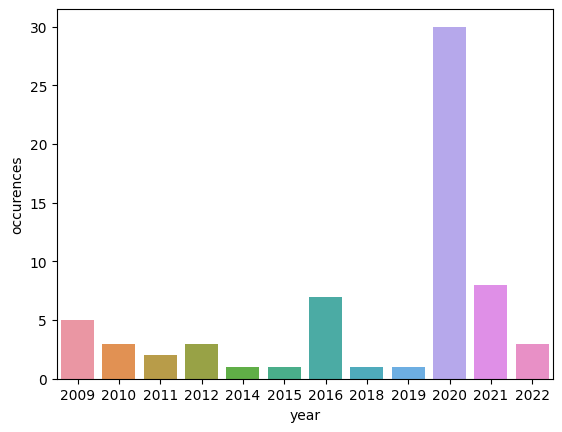

In [60]:
sns.barplot(data=plot_data,x='year',y='occurences')

### <font color=#ffa07a> Exploring Anamolies in Different Sectors </font>

In [61]:
high_rise=anamolies_detection[anamolies_detection.z_score>2.5]

In [62]:
px.bar(data_frame=high_rise.year.value_counts())

In [63]:
high_rise['label']=high_rise.Function+' '+high_rise.year.astype('str')

In [64]:
px.bar(data_frame=high_rise.label.value_counts())

In [65]:
high_drop=anamolies_detection[anamolies_detection.z_score<=-2.5]

In [66]:
px.bar(high_drop.year.value_counts())

In [67]:
high_drop['label']=high_drop.Function+' '+high_drop.year.astype('str')

In [68]:
px.bar(data_frame=high_drop.label.value_counts())

## <font color = #D5B85A>  Machine learning model to predict expenditure  by per capita income

In [70]:
data=pd.read_excel('gdp.xlsx',sheet_name=None)

In [71]:
keys=list(data.keys())

In [72]:
gdp_per_capita=data[keys[0]].melt(id_vars='Country',var_name='year',value_name=keys[0])

In [73]:
expenditure=data[keys[1]].melt(id_vars='Country',var_name='year',value_name='expenditure')

In [74]:
expenditure.head(),expenditure.shape

(     Country  year  expenditure
 0  Argentina  1991    11.432200
 1  Australia  1991    38.093281
 2     Brazil  1991    38.391540
 3     Canada  1991    52.263802
 4      China  1991    16.642829,
 (620, 3))

In [75]:
gdp_per_capita.head(),gdp_per_capita.shape

(                Country  year  gdp_per_capita
 0             Australia  1991       -1.644753
 1        European Union  1991        1.512103
 2        United Kingdom  1991       -1.408486
 3         United States  1991       -1.434200
 4  United Arab Emirates  1991       -4.575280,
 (620, 3))

In [76]:
ml_data=gdp_per_capita.merge(expenditure,on=['Country','year'])

### <font color=#ffa07a> Checking for linearity and only trying to predict by gdp per capita and past expenditures </font>

In [77]:
ml_data.groupby('Country').year.nunique()

Country
Argentina               31
Australia               31
Brazil                  31
Canada                  31
China                   31
France                  31
Germany                 31
India                   31
Indonesia               31
Italy                   31
Japan                   31
Russia                  31
Saudi Arabia            31
South Africa            31
Turkey                  31
United Arab Emirates    31
United Kingdom          31
United States           31
Name: year, dtype: int64

In [78]:
plot_data=ml_data.groupby('year')[['expenditure','gdp_per_capita']].agg('mean').reset_index()

In [79]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

In [80]:
fig.add_trace(
    go.Scatter(x=plot_data['year'], y=plot_data['expenditure'], name="expenditure"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=plot_data['year'], y=plot_data['gdp_per_capita'], name="per_capita"),
    secondary_y=True,
)

<Axes: xlabel='gdp_per_capita', ylabel='Count'>

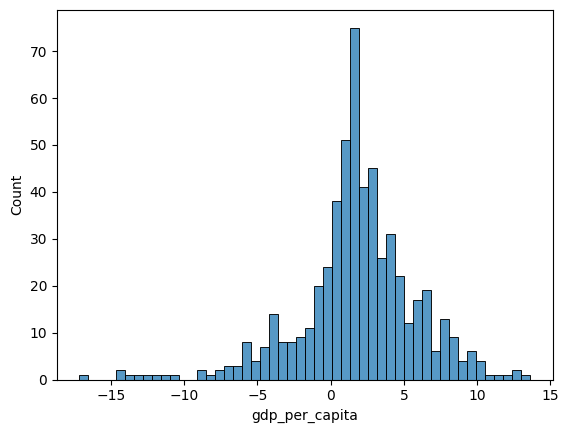

In [81]:
sns.histplot(ml_data.gdp_per_capita,bins=50)

<Axes: xlabel='expenditure', ylabel='Count'>

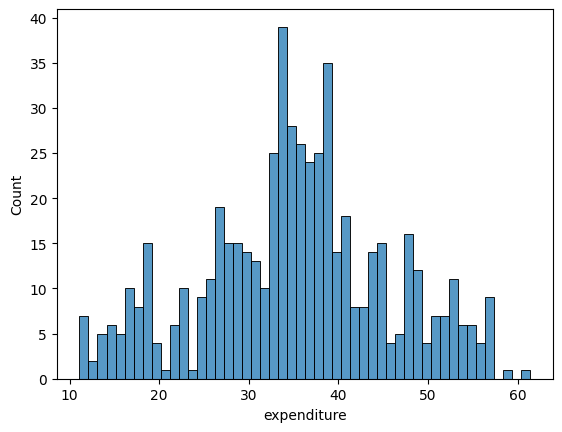

In [82]:
sns.histplot(ml_data.expenditure,bins=50)

In [ ]:
ml_data.head()

##### Hide

In [83]:
# Finding percentage change in expenditure across years
def partition_year(data):
    final=pd.DataFrame()
    for key,df in data.groupby(['Country']):
        df['spent_change']=df.expenditure.pct_change()
        final=pd.concat([final,df],ignore_index=True)
    return(final)


In [84]:
data_change=partition_year(ml_data)

<ipython-input-83-aae19054ee42>:4: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [85]:
plot_data=data_change.groupby('year')[['spent_change','gdp_per_capita']].agg('mean').reset_index()

In [86]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

In [87]:
fig.add_trace(
    go.Scatter(x=plot_data['year'], y=plot_data['spent_change'], name="expenditure"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(x=plot_data['year'], y=plot_data['gdp_per_capita'], name="per_capita"),
    secondary_y=True,
)

<Axes: xlabel='spent_change', ylabel='Count'>

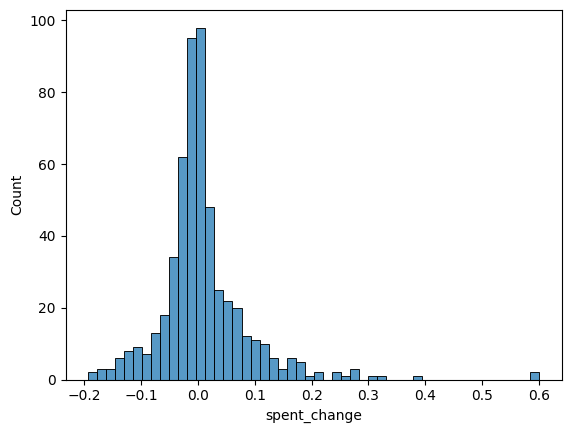

In [88]:
sns.histplot(data_change.spent_change,bins=50)

<Axes: xlabel='gdp_per_capita', ylabel='Count'>

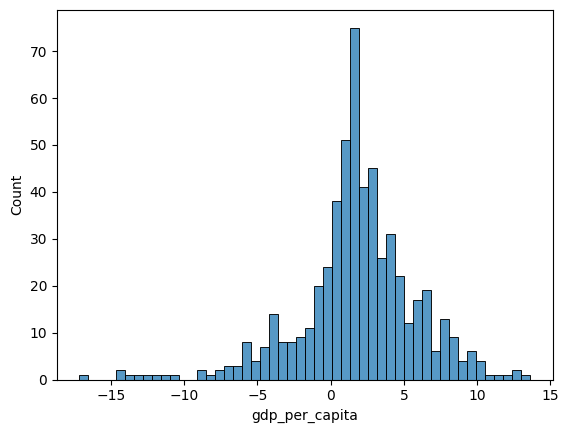

In [89]:
sns.histplot(data_change.gdp_per_capita,bins=50)

### <font color=#ffa07a> Trying prediction with ARIMA

In [90]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',FutureWarning)

In [91]:
stat_data=data_change.groupby('year').spent_change.mean().dropna().reset_index()

In [92]:
stat_data.year=pd.to_datetime(stat_data.year,format='%Y')

In [93]:
print(stat_data.spent_change.autocorr(1),
stat_data.spent_change.autocorr(2),
stat_data.spent_change.autocorr(3),
stat_data.spent_change.autocorr(4),
stat_data.spent_change.autocorr(5),
     stat_data.spent_change.autocorr(6))

-0.14479937984630903 -0.19390331440655367 -0.21945718745216883 -0.058797983007123834 -0.05603468031715083 -0.01405651865915723


## <font color=#D5B85A> Machine Learning Model To Predict Government Expenditure by Multiple Economic Indicators

In [95]:
data=pd.read_excel('indicators.xlsx',sheet_name=None)

In [96]:
keys=data.keys()

In [97]:
## Creating dataframe from extracted sheets
def create(keys,data):
    final_df=pd.DataFrame()
    for i in keys:
        df=data[i]
        df_melt=df.melt(id_vars=['Country','indicator'],var_name='year',value_name='values')
        final_df=pd.concat([df_melt,final_df],ignore_index=True)
    return(final_df)

In [98]:
f=create(keys,data)

In [99]:
f.Country.value_counts()

United States           155
Indonesia               155
Australia               155
Brazil                  155
Canada                  155
China                   155
France                  155
Germany                 155
India                   155
Italy                   155
United Kingdom          155
Mexico                  155
Russia                  155
Saudi Arabia            155
South Africa            155
South Korea             155
Turkiye                 155
United Arab Emirates    155
Argentina               155
Name: Country, dtype: int64

### <font color=#ffa07a> Preprocessing For Machine Learning

In [100]:
indicator=f.pivot_table('values',['Country','year'],'indicator').reset_index()

<ipython-input-101-a170ce40ce1c>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: xlabel='indicator', ylabel='indicator'>

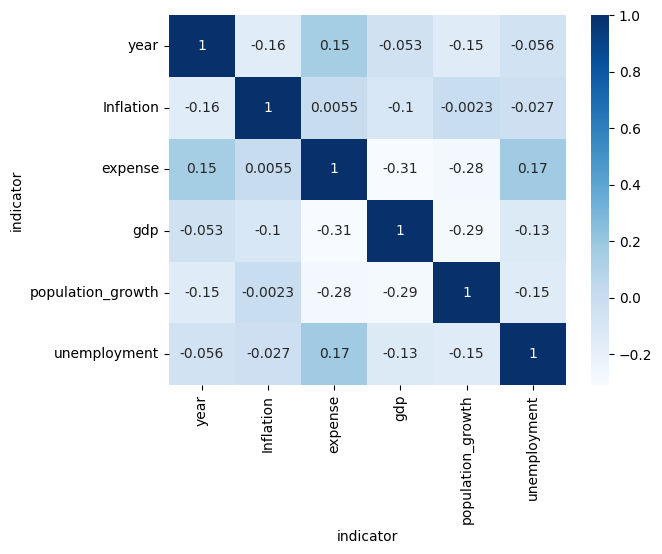

In [101]:
sns.heatmap(indicator.corr(),cmap='Blues',annot=True)

In [102]:
model_data=pd.get_dummies(indicator,columns=['Country'])

In [103]:
model_data.year=pd.to_datetime(model_data.year,format='%Y')

In [104]:
model_data.head()

,year,Inflation,expense,gdp,population_growth,unemployment,Country_Argentina,Country_Australia,Country_Brazil,Country_Canada,...,Country_Italy,Country_Mexico,Country_Russia,Country_Saudi Arabia,Country_South Africa,Country_South Korea,Country_Turkiye,Country_United Arab Emirates,Country_United Kingdom,Country_United States
0,1991-01-01,140.502379,11.4322,7.590000,1.424063,5.44,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1992-01-01,16.071994,12.0994,6.450073,1.387435,6.36,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1993-01-01,-3.561096,13.3105,6.747497,1.357966,10.10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1994-01-01,2.849340,14.1744,4.420121,1.347024,11.76,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1995-01-01,3.165123,14.3942,-4.116881,1.317554,18.80,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
# scaling
scaled_values=MinMaxScaler().fit_transform(model_data[['Inflation','expense','gdp','population_growth','unemployment']])

In [106]:
model_data[['Inflation','expense','gdp','population_growth','unemployment']]=scaled_values

In [107]:
model_data['year']=model_data.year.dt.year

In [108]:
# X and y (data and labels)
X=model_data.drop(columns='expense')
y=model_data[['expense']]

In [109]:
## puttinig data before 2017 for training
train_index=X[X.year<2017].index

In [110]:
### after 2017 for testing
test_index=X[X.year>2017].index

In [111]:
X_train=X.iloc[train_index]
y_train=y.iloc[train_index]

In [112]:
X_test=X.iloc[test_index]
y_test=y.iloc[test_index]

In [113]:
X_train.shape,X_test.shape

((494, 24), (76, 24))

### <font color=#ffa07a> Using Random Forest Regressor for Prediction

In [114]:
forest=RandomForestRegressor(random_state=73)

In [115]:
forest.fit(X_train,np.ravel(y_train))

RandomForestRegressor(random_state=73)

In [116]:
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 73,
 'verbose': 0,
 'warm_start': False}

In [117]:
forest.score(X_train,y_train)

0.9876161084027679

In [118]:
y_pred=forest.predict(X_test)

In [120]:
mape=mean_absolute_percentage_error(y_test,y_pred)

In [121]:
1-mape

0.7843758662930156

In [122]:
extract=pd.DataFrame(list(X_train.columns),forest.feature_importances_).reset_index()

In [123]:
extract.rename(columns={0:'feature','index':'importance'},inplace=True)

In [124]:
plot_data=extract.sort_values('importance',ascending=False).head(10)

In [125]:
px.bar(x=plot_data.feature,y=plot_data.importance)

## <font color=#D5B85A> Tableau </font>
   Link : https://public.tableau.com/app/profile/dhruv.parikh7989/viz/G20study/Dashboard5?publish=yes